# <font color='cornflowerblue'>Anomaly Detection in Data</font>


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv
from scipy.spatial import distance
from sklearn.neighbors import KNeighborsClassifier
from sklearn import cluster
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN

import warnings
warnings.filterwarnings("ignore")

## Load in data:

In [2]:
compound = pd.read_csv('compound.txt', sep='\s+', header=None)
compound.head(3)

,0,1,2
0,26.75,22.15,1
1,29.80,22.15,1
2,31.55,21.10,1


In [3]:
compoundX = compound.drop(compound.columns[-1], axis=1)
compoundX.columns = ['feature_1', 'feature_2']
compoundX

,feature_1,feature_2
0,26.75,22.15
1,29.80,22.15
2,31.55,21.10
3,27.70,20.85
4,29.90,19.95
...,...,...
394,15.85,9.95
395,15.35,9.90
396,15.60,9.45
397,15.30,9.15


In [4]:
flame = pd.read_csv('flame.txt', sep='\s+', header=None)
flame.head(3)

,0,1,2
0,1.85,27.80,1
1,1.35,26.65,1
2,1.40,23.25,2


In [5]:
flameX = flame.drop(flame.columns[-1], axis=1)
flameX.columns = ['feature_1', 'feature_2']
flameX

,feature_1,feature_2
0,1.85,27.80
1,1.35,26.65
2,1.40,23.25
3,0.85,23.05
4,0.50,22.35
...,...,...
235,7.50,26.20
236,7.50,25.65
237,7.05,25.85
238,6.90,27.15


In [6]:
pathbased = pd.read_csv('pathbased.txt', sep='\s+', header=None)
pathbased.head(3)

,0,1,2
0,11.25,5.05,1
1,10.95,4.70,1
2,9.85,5.80,1


In [7]:
pathbasedX = pathbased.drop(pathbased.columns[-1], axis=1)
pathbasedX.columns = ['feature_1', 'feature_2']
pathbasedX

,feature_1,feature_2
0,11.25,5.05
1,10.95,4.70
2,9.85,5.80
3,9.80,5.75
4,9.15,6.80
...,...,...
295,17.50,18.05
296,16.65,17.50
297,15.45,17.30
298,15.45,17.80


---

# Part I (Using Parametric Models):


In [8]:
col_names = ['X', 'Y']
gdata = pd.read_csv('G-data.csv', sep=',', header=None, names=col_names)
gdata

,X,Y
0,8.724514,16.680705
1,8.111094,14.039865
2,3.891538,11.217337
3,6.595019,16.108606
4,9.159665,15.282327
...,...,...
245,3.156732,13.434926
246,6.588365,15.036372
247,7.806401,13.882248
248,8.672002,14.524847


In [9]:
meanValue = gdata.mean()
covValue = gdata.cov()
print(f'Mean \n{meanValue}')
print(f'\nCovariance \n{covValue}')

Mean 
X     6.161942
Y    14.004147
dtype: float64

Covariance 
          X         Y
X  3.541314  2.449140
Y  2.449140  3.230053


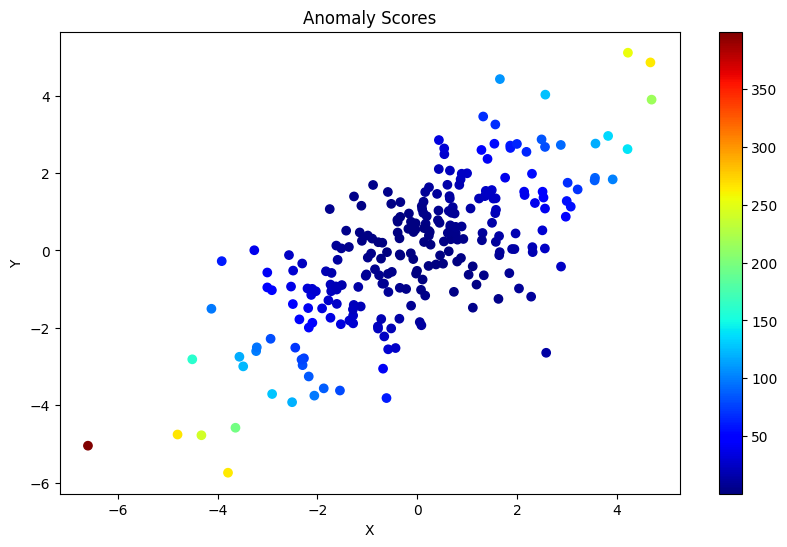

In [10]:
X = gdata.to_numpy()
S = covValue.to_numpy()
for i in range(2):
    X[:,i] = X[:,i] - meanValue[i]
    
def mahalanobis(row):
    return np.matmul(row,S).dot(row)   
    
anomaly_score = np.apply_along_axis(mahalanobis, axis=1, arr=X)

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
p = ax.scatter(gdata.X, gdata.Y, c=anomaly_score, cmap='jet')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Anomaly Scores')
fig.colorbar(p)
plt.show()

*Figure 1. Anomaly scores using a parametric model*
- The greatest anomaly score is the red-brown point seen in the lower left side of the cluster
- As X and Y get smaller (more negative), the anomaly scores increase 

In [11]:
anom = pd.DataFrame(anomaly_score, index=gdata.index, columns=['Anomaly score'])
result = pd.concat((gdata, anom), axis=1)
result.nlargest(5,'Anomaly score')

,X,Y,Anomaly score
8,-6.600549,-5.045834,399.662410
94,-4.804438,-4.756795,266.773486
89,4.675894,4.860870,265.079681
26,-3.793011,-5.744357,264.258449
204,4.224742,5.111333,253.368184


---

# Part II (Using Distance-based Models):


In [12]:
def dbm(dataX):
    k = [1,2,5]
    for knn in k:
        # distance to the k'th nearest neighbour
        nbrs = NearestNeighbors(n_neighbors=knn, metric=distance.euclidean).fit(dataX.to_numpy())
        distances, indices = nbrs.kneighbors(dataX.to_numpy()) #d bwtn each point and 1 nn
        
        # top 5 points of anomaly
        anomaly_score = distances[:, knn-1] # one spec col. of distances
        anom = pd.DataFrame(anomaly_score, index=dataX.index, columns=['Anomaly score'])
        result = pd.concat((dataX,anom), axis=1)
        print(f'Anomaly Score (k={knn})')
        print(result.nlargest(5,'Anomaly score').to_markdown())
        
        # scatter plots
        fig = plt.figure(figsize=(9,5))
        ax = fig.add_subplot(111)
        p = ax.scatter(dataX.feature_1, dataX.feature_2, c=anomaly_score, cmap='jet')
        ax.set_xlabel('feature_1')
        ax.set_ylabel('feature_2')
        fig.colorbar(p)
        plt.show()

# <font color='blueviolet'>Compound</font>

Anomaly Score (k=1)
|    |   feature_1 |   feature_2 |   Anomaly score |
|---:|------------:|------------:|----------------:|
|  0 |       26.75 |       22.15 |               0 |
|  1 |       29.8  |       22.15 |               0 |
|  2 |       31.55 |       21.1  |               0 |
|  3 |       27.7  |       20.85 |               0 |
|  4 |       29.9  |       19.95 |               0 |


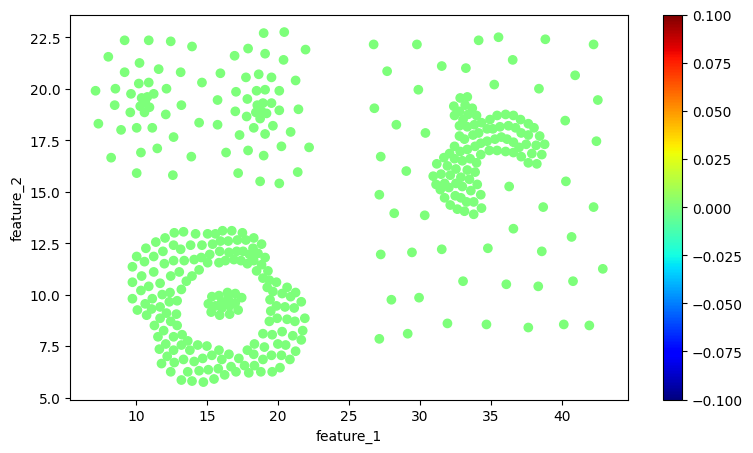

Anomaly Score (k=2)
|    |   feature_1 |   feature_2 |   Anomaly score |
|---:|------------:|------------:|----------------:|
| 43 |       38.85 |       22.4  |         2.44182 |
| 22 |       34.7  |        8.55 |         2.40052 |
| 21 |       31.95 |        8.6  |         2.32648 |
| 13 |       27.25 |       11.95 |         2.20227 |
| 36 |       42.9  |       11.25 |         2.18403 |


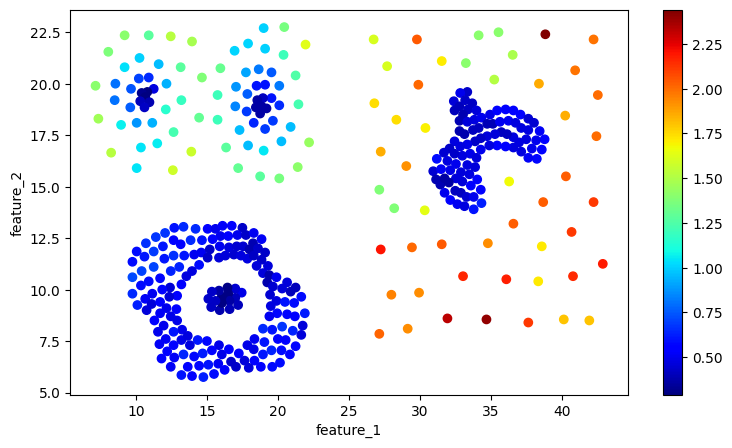

Anomaly Score (k=5)
|    |   feature_1 |   feature_2 |   Anomaly score |
|---:|------------:|------------:|----------------:|
| 42 |       42.25 |       22.15 |         4.20595 |
| 19 |       27.15 |        7.85 |         4.10122 |
| 37 |       41.95 |        8.5  |         4.07063 |
|  0 |       26.75 |       22.15 |         3.8422  |
| 43 |       38.85 |       22.4  |         3.30151 |


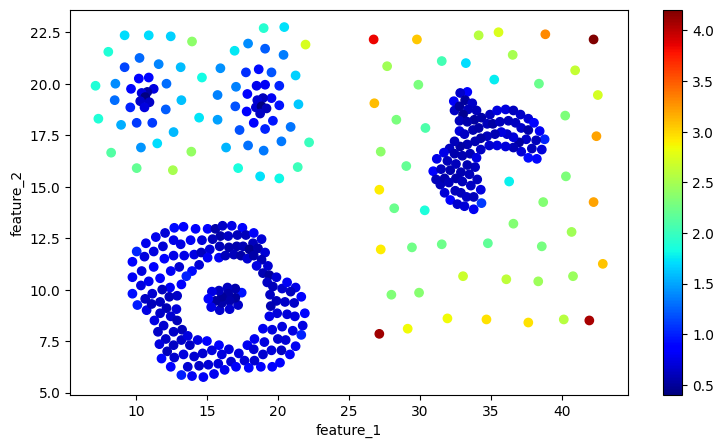

In [13]:
dbm(compoundX)

*Figure 2. Many figures of anomaly scores using a distance-based model*
- When k=1, the distances do not have anomalies because it is one cluster 
   - since all distances are 0, k=1 should be all 0 for anomaly
- With increased distance (neighbours) we have a greater anomaly

# <font color='crimson'>Flame</font>

Anomaly Score (k=1)
|    |   feature_1 |   feature_2 |   Anomaly score |
|---:|------------:|------------:|----------------:|
|  0 |        1.85 |       27.8  |               0 |
|  1 |        1.35 |       26.65 |               0 |
|  2 |        1.4  |       23.25 |               0 |
|  3 |        0.85 |       23.05 |               0 |
|  4 |        0.5  |       22.35 |               0 |


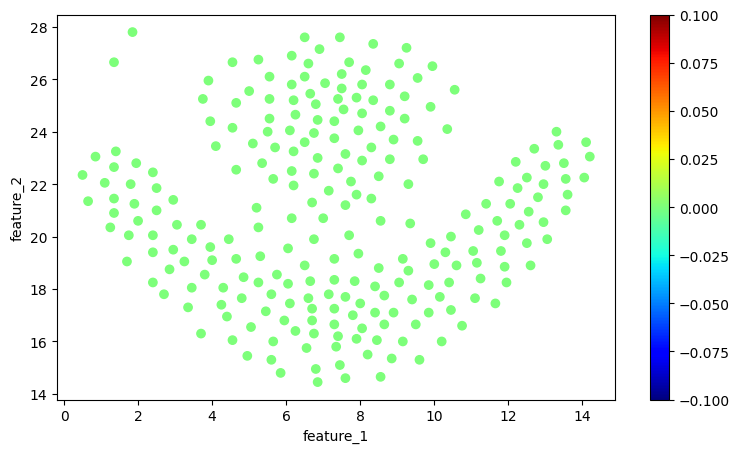

Anomaly Score (k=2)
|     |   feature_1 |   feature_2 |   Anomaly score |
|----:|------------:|------------:|----------------:|
|   0 |        1.85 |       27.8  |        1.25399  |
|   1 |        1.35 |       26.65 |        1.25399  |
| 204 |       10.55 |       25.6  |        0.919239 |
| 192 |       10.35 |       24.1  |        0.917878 |
| 201 |        8.35 |       27.35 |        0.912414 |


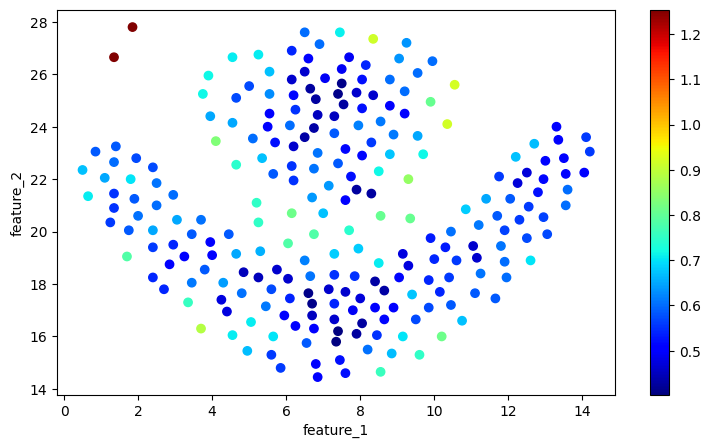

Anomaly Score (k=5)
|     |   feature_1 |   feature_2 |   Anomaly score |
|----:|------------:|------------:|----------------:|
|   1 |        1.35 |       26.65 |         3.2     |
|   0 |        1.85 |       27.8  |         3.18002 |
| 204 |       10.55 |       25.6  |         1.37295 |
| 158 |        9.35 |       20.5  |         1.36473 |
| 192 |       10.35 |       24.1  |         1.32098 |


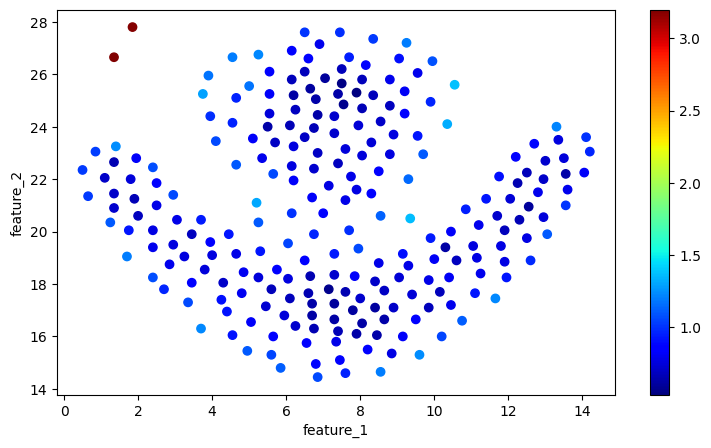

In [14]:
dbm(flameX)

*Figure 3. Many figures of anomaly scores using a distance-based model*
- When k=1, the distances do not have anomalies because it is one cluster 
   - since all distances are 0, k=1 should be all 0 for anomaly
- With increased distance (neighbours) we have a greater anomaly

# <font color='violet'>PathBased</font>

Anomaly Score (k=1)
|    |   feature_1 |   feature_2 |   Anomaly score |
|---:|------------:|------------:|----------------:|
|  0 |       11.25 |        5.05 |               0 |
|  1 |       10.95 |        4.7  |               0 |
|  2 |        9.85 |        5.8  |               0 |
|  3 |        9.8  |        5.75 |               0 |
|  4 |        9.15 |        6.8  |               0 |


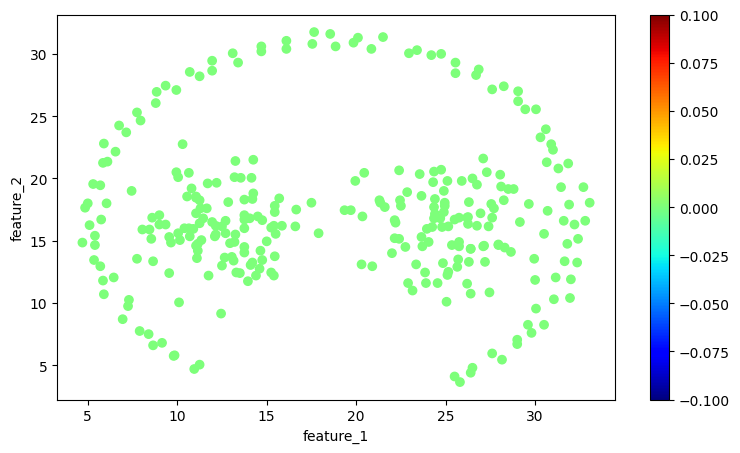

Anomaly Score (k=2)
|     |   feature_1 |   feature_2 |   Anomaly score |
|----:|------------:|------------:|----------------:|
| 202 |       12.45 |        9.15 |         2.51645 |
| 203 |       10.1  |       10.05 |         2.4135  |
| 270 |       10.3  |       22.75 |         2.27706 |
| 266 |        7.45 |       19    |         1.72047 |
| 106 |       29.15 |       16.5  |         1.53379 |


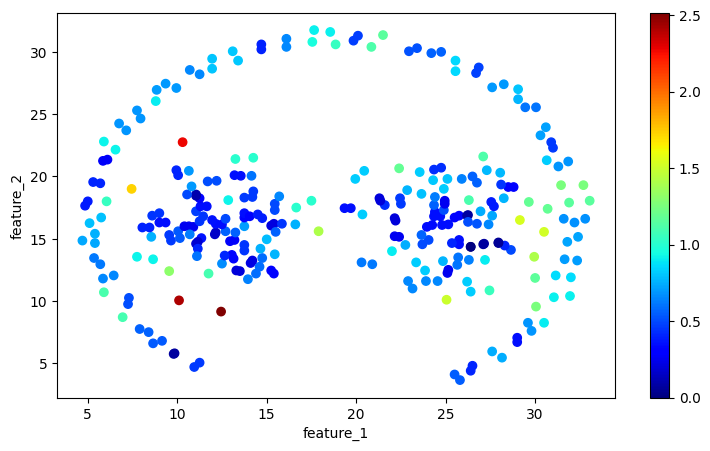

Anomaly Score (k=5)
|     |   feature_1 |   feature_2 |   Anomaly score |
|----:|------------:|------------:|----------------:|
| 202 |       12.45 |        9.15 |         3.40771 |
| 270 |       10.3  |       22.75 |         3.022   |
| 101 |       25.8  |        3.65 |         2.92062 |
| 144 |       20.3  |       13.1  |         2.82179 |
| 203 |       10.1  |       10.05 |         2.80713 |


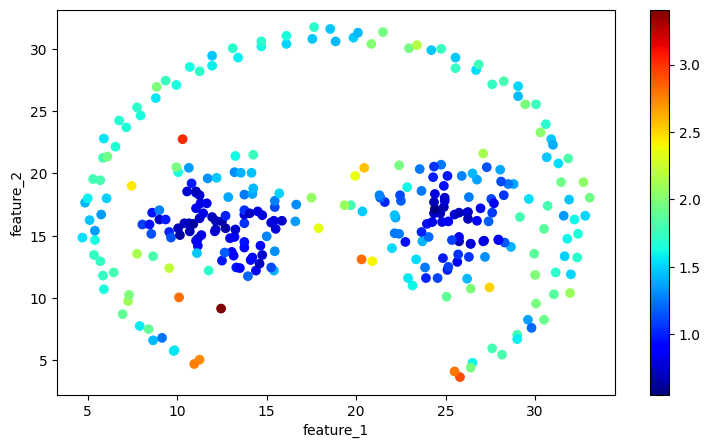

In [15]:
dbm(pathbasedX)

*Figure 4. Many figures of anomaly scores using a distance-based model*
- When k=1, the distances do not have anomalies because it is one cluster 
   - since all distances are 0, k=1 should be all 0 for anomaly
- With increased distance (neighbours) we have a greater anomaly

---

# Part III (Using Density-based Models):


### A. Density is the inverse of distance to k’th neighbour (for k = 1, 2, 5)

In [16]:
def dbm_inverse(dataX):
    k = [1,2,5]
    for knn in k:
        # distance to the k'th nearest neighbour
        nbrs = NearestNeighbors(n_neighbors=knn, metric=distance.euclidean).fit(dataX.to_numpy())
        distances, indices = nbrs.kneighbors(dataX.to_numpy()) 
        
        # top 5 points of anomaly (nsmallest as increased distance lowers the density)
        # highest density points are not anomalies (density = 1/distance -> ananonly)
        anomaly_score = 1/distances[:, knn-1] # inverse
        anom = pd.DataFrame(anomaly_score, index=dataX.index, columns=['Anomaly score'])
        result = pd.concat((dataX,anom), axis=1)
        print(f'Anomaly Score (k={knn})')
        print(result.nsmallest(5,'Anomaly score').to_markdown()) # get smallest
        
        # scatter plots
        fig = plt.figure(figsize=(9,5))
        ax = fig.add_subplot(111)
        p = ax.scatter(dataX.feature_1, dataX.feature_2, c=anomaly_score, cmap='jet')
        ax.set_xlabel('feature_1')
        ax.set_ylabel('feature_2')
        plt.title(f'Anomaly Score (k={knn})')
        fig.colorbar(p)
        plt.show()

# <font color='blueviolet'>Compound</font>

Anomaly Score (k=1)
|    |   feature_1 |   feature_2 |   Anomaly score |
|---:|------------:|------------:|----------------:|
|  0 |       26.75 |       22.15 |             inf |
|  1 |       29.8  |       22.15 |             inf |
|  2 |       31.55 |       21.1  |             inf |
|  3 |       27.7  |       20.85 |             inf |
|  4 |       29.9  |       19.95 |             inf |


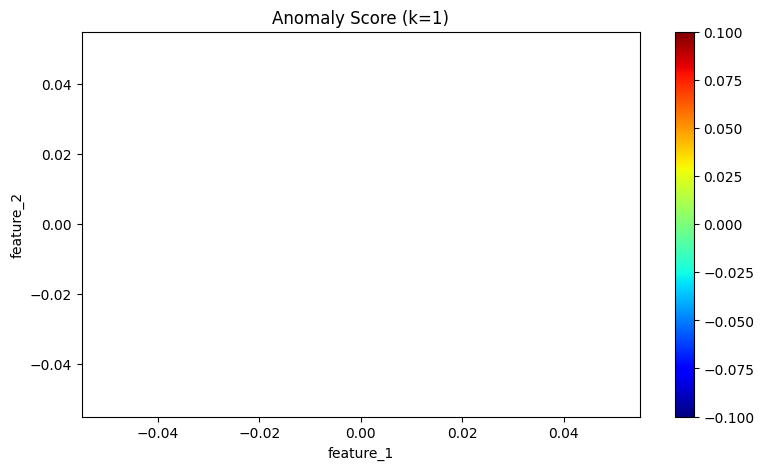

Anomaly Score (k=2)
|    |   feature_1 |   feature_2 |   Anomaly score |
|---:|------------:|------------:|----------------:|
| 43 |       38.85 |       22.4  |        0.40953  |
| 22 |       34.7  |        8.55 |        0.416576 |
| 21 |       31.95 |        8.6  |        0.429834 |
| 13 |       27.25 |       11.95 |        0.454077 |
| 36 |       42.9  |       11.25 |        0.457869 |


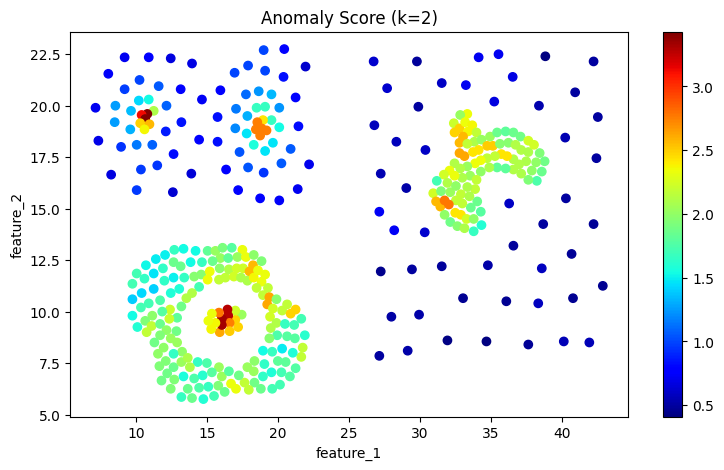

Anomaly Score (k=5)
|    |   feature_1 |   feature_2 |   Anomaly score |
|---:|------------:|------------:|----------------:|
| 42 |       42.25 |       22.15 |        0.237759 |
| 19 |       27.15 |        7.85 |        0.24383  |
| 37 |       41.95 |        8.5  |        0.245662 |
|  0 |       26.75 |       22.15 |        0.260268 |
| 43 |       38.85 |       22.4  |        0.302891 |


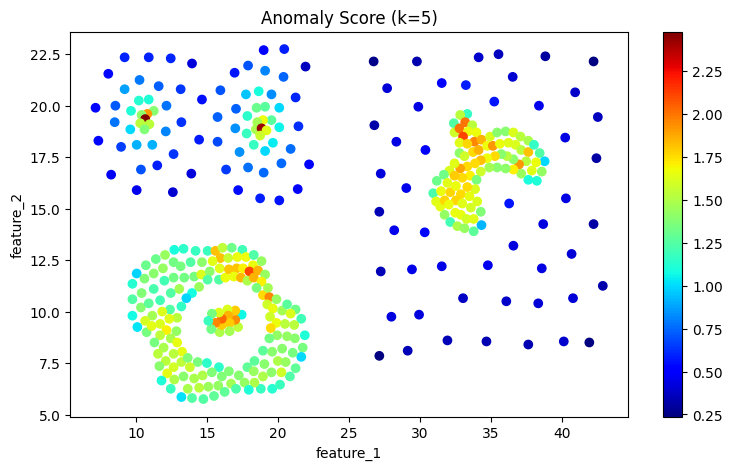

In [17]:
dbm_inverse(compoundX)

*Figure 5. Many figures of anomaly scores using a density-based model*
- When k=1, we have zero division error -> inf
- With increased distance (neighbours) we have greater anomaly given the decreased density  
  - the lowest density (anomaly score) implies bigger anomaly

# <font color='crimson'>Flame</font>

Anomaly Score (k=1)
|    |   feature_1 |   feature_2 |   Anomaly score |
|---:|------------:|------------:|----------------:|
|  0 |        1.85 |       27.8  |             inf |
|  1 |        1.35 |       26.65 |             inf |
|  2 |        1.4  |       23.25 |             inf |
|  3 |        0.85 |       23.05 |             inf |
|  4 |        0.5  |       22.35 |             inf |


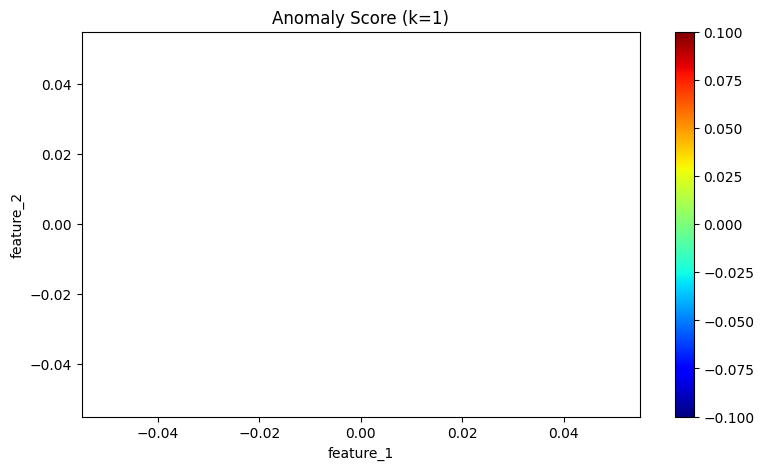

Anomaly Score (k=2)
|     |   feature_1 |   feature_2 |   Anomaly score |
|----:|------------:|------------:|----------------:|
|   0 |        1.85 |       27.8  |        0.797452 |
|   1 |        1.35 |       26.65 |        0.797452 |
| 204 |       10.55 |       25.6  |        1.08786  |
| 192 |       10.35 |       24.1  |        1.08947  |
| 201 |        8.35 |       27.35 |        1.09599  |


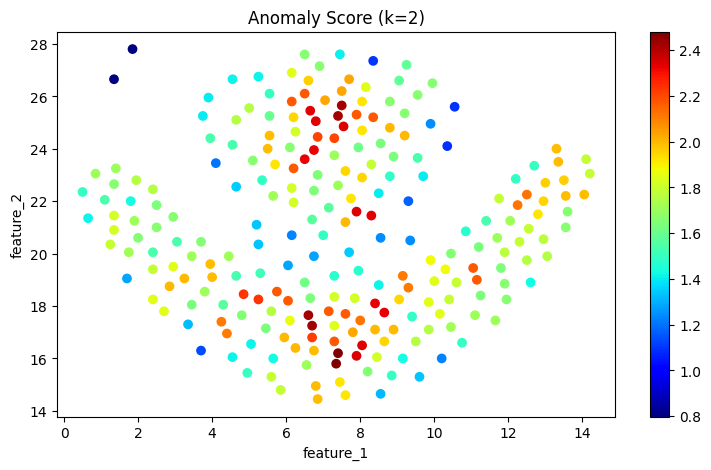

Anomaly Score (k=5)
|     |   feature_1 |   feature_2 |   Anomaly score |
|----:|------------:|------------:|----------------:|
|   1 |        1.35 |       26.65 |        0.3125   |
|   0 |        1.85 |       27.8  |        0.314464 |
| 204 |       10.55 |       25.6  |        0.728357 |
| 158 |        9.35 |       20.5  |        0.732743 |
| 192 |       10.35 |       24.1  |        0.757011 |


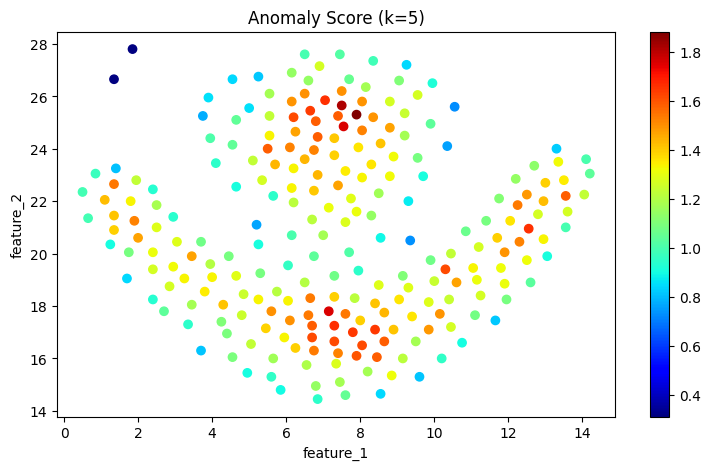

In [18]:
dbm_inverse(flameX)

*Figure 6. Many figures of anomaly scores using a density-based model*
- When k=1, we have zero division error -> inf
- With increased distance (neighbours) we have greater anomaly given the decreased density  
  - the lowest density (anomaly score) implies bigger anomaly

# <font color='violet'>PathBased</font>

Anomaly Score (k=1)
|    |   feature_1 |   feature_2 |   Anomaly score |
|---:|------------:|------------:|----------------:|
|  0 |       11.25 |        5.05 |             inf |
|  1 |       10.95 |        4.7  |             inf |
|  2 |        9.85 |        5.8  |             inf |
|  3 |        9.8  |        5.75 |             inf |
|  4 |        9.15 |        6.8  |             inf |


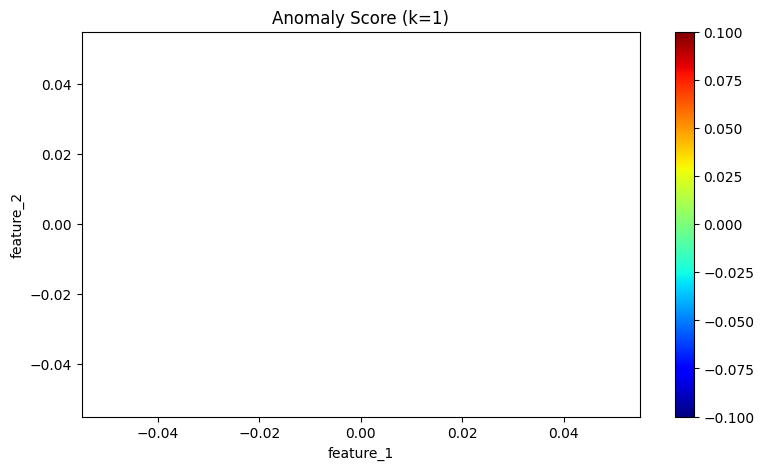

Anomaly Score (k=2)
|     |   feature_1 |   feature_2 |   Anomaly score |
|----:|------------:|------------:|----------------:|
| 202 |       12.45 |        9.15 |        0.397386 |
| 203 |       10.1  |       10.05 |        0.414335 |
| 270 |       10.3  |       22.75 |        0.439163 |
| 266 |        7.45 |       19    |        0.581238 |
| 106 |       29.15 |       16.5  |        0.651981 |


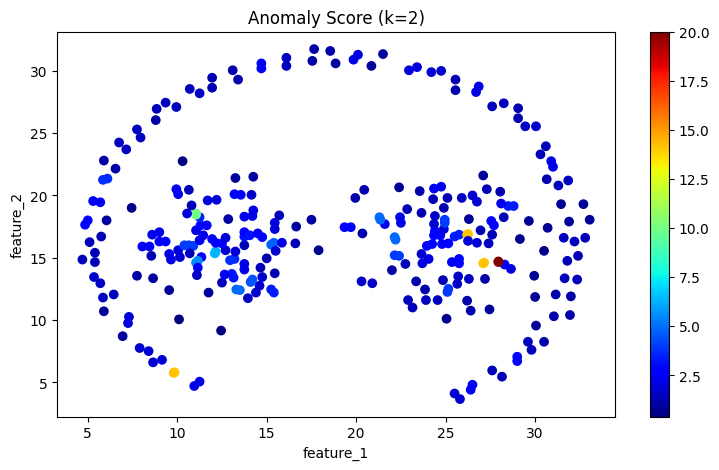

Anomaly Score (k=5)
|     |   feature_1 |   feature_2 |   Anomaly score |
|----:|------------:|------------:|----------------:|
| 202 |       12.45 |        9.15 |        0.293452 |
| 270 |       10.3  |       22.75 |        0.330906 |
| 101 |       25.8  |        3.65 |        0.342393 |
| 144 |       20.3  |       13.1  |        0.354385 |
| 203 |       10.1  |       10.05 |        0.356235 |


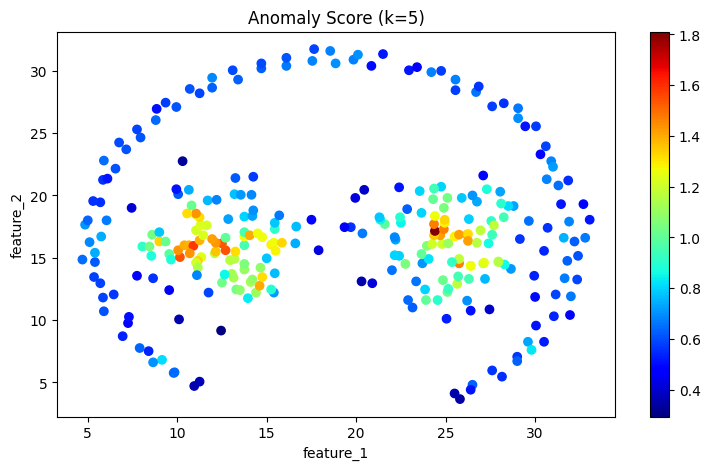

In [19]:
dbm_inverse(pathbasedX)

*Figure 7. Many figures of anomaly scores using a density-based model*
- When k=1, we have zero division error -> inf
- With increased distance (neighbours) we have greater anomaly given the decreased density  
  - the lowest density (anomaly score) implies bigger anomaly

### B. Density is the inverse of the average distance between the k neighbours (for k = 1, 2, 5)

In [20]:
def dbm_inverse_avg(dataX):
    k = [1,2,5]
    for knn in k:
        # distance to the k'th nearest neighbour
        nbrs = NearestNeighbors(n_neighbors=knn, metric=distance.euclidean).fit(dataX.to_numpy())
        distances, indices = nbrs.kneighbors(dataX.to_numpy()) 
       
        # get the average distance row-wise
        avg_dist = np.mean(distances, axis=1)
        anomaly_score = 1/avg_dist
        
        # top 5 points of anomaly (nsmallest as increased distance lowers the density)
        # highest density points are not anomalies (density = 1/distance -> ananonly)
        anom = pd.DataFrame(anomaly_score, index=dataX.index, columns=['Anomaly score'])
        result = pd.concat((dataX,anom), axis=1)
        print(f'Anomaly Score (k={knn})')
        print(result.nsmallest(5,'Anomaly score').to_markdown()) # get smallest
        
        # scatter plots
        fig = plt.figure(figsize=(9,5))
        ax = fig.add_subplot(111)
        p = ax.scatter(dataX.feature_1, dataX.feature_2, c=anomaly_score, cmap='jet')
        ax.set_xlabel('feature_1')
        ax.set_ylabel('feature_2')
        plt.title(f'Anomaly Score (k={knn})')
        fig.colorbar(p)
        plt.show()

# <font color='blueviolet'>Compound</font>

Anomaly Score (k=1)
|    |   feature_1 |   feature_2 |   Anomaly score |
|---:|------------:|------------:|----------------:|
|  0 |       26.75 |       22.15 |             inf |
|  1 |       29.8  |       22.15 |             inf |
|  2 |       31.55 |       21.1  |             inf |
|  3 |       27.7  |       20.85 |             inf |
|  4 |       29.9  |       19.95 |             inf |


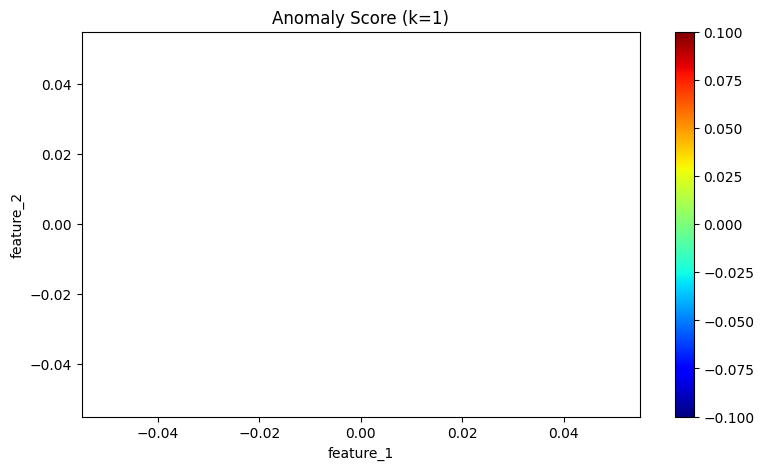

Anomaly Score (k=2)
|    |   feature_1 |   feature_2 |   Anomaly score |
|---:|------------:|------------:|----------------:|
| 43 |       38.85 |       22.4  |        0.81906  |
| 22 |       34.7  |        8.55 |        0.833153 |
| 21 |       31.95 |        8.6  |        0.859669 |
| 13 |       27.25 |       11.95 |        0.908153 |
| 36 |       42.9  |       11.25 |        0.915737 |


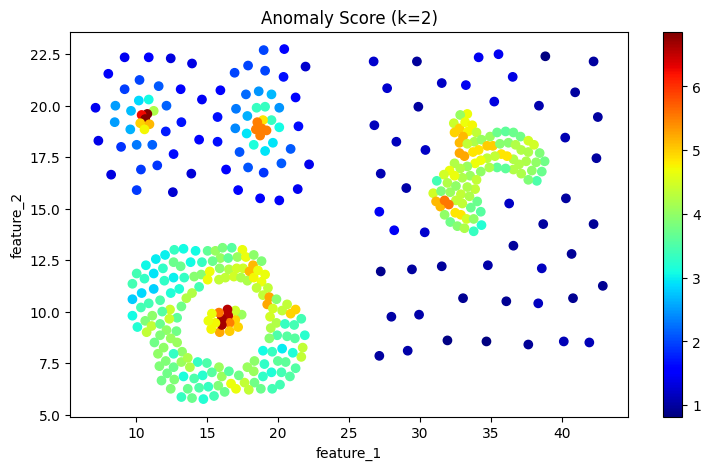

Anomaly Score (k=5)
|    |   feature_1 |   feature_2 |   Anomaly score |
|---:|------------:|------------:|----------------:|
| 42 |       42.25 |       22.15 |        0.405953 |
| 19 |       27.15 |        7.85 |        0.429584 |
|  0 |       26.75 |       22.15 |        0.430933 |
| 37 |       41.95 |        8.5  |        0.445672 |
| 43 |       38.85 |       22.4  |        0.45517  |


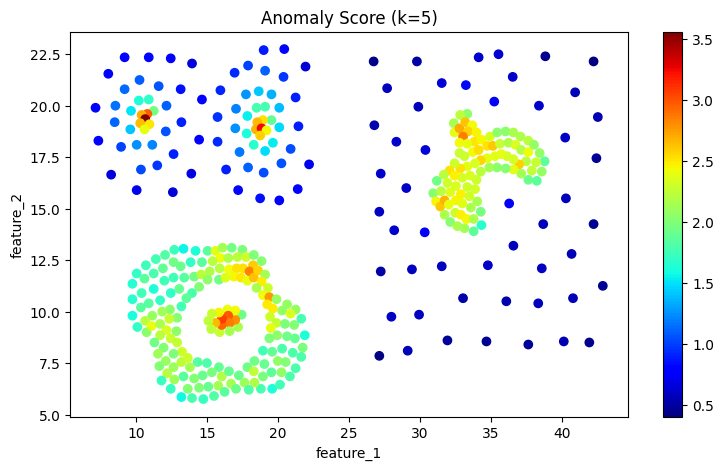

In [21]:
dbm_inverse_avg(compoundX)

*Figure 8. Many figures of anomaly scores using a density-based (average) model*
- When k=1, we have zero division error -> inf
- With increased distance (neighbours) we have greater anomaly given the decreased density 
  - the lowest density (anomaly score) implies bigger anomaly 
  - the density is based on the averaged distances of rows for different k 

# <font color='crimson'>Flame</font>

Anomaly Score (k=1)
|    |   feature_1 |   feature_2 |   Anomaly score |
|---:|------------:|------------:|----------------:|
|  0 |        1.85 |       27.8  |             inf |
|  1 |        1.35 |       26.65 |             inf |
|  2 |        1.4  |       23.25 |             inf |
|  3 |        0.85 |       23.05 |             inf |
|  4 |        0.5  |       22.35 |             inf |


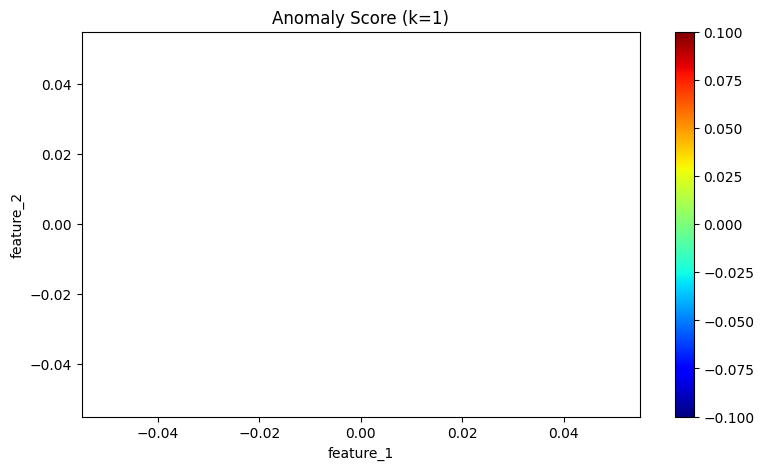

Anomaly Score (k=2)
|     |   feature_1 |   feature_2 |   Anomaly score |
|----:|------------:|------------:|----------------:|
|   0 |        1.85 |       27.8  |         1.5949  |
|   1 |        1.35 |       26.65 |         1.5949  |
| 204 |       10.55 |       25.6  |         2.17571 |
| 192 |       10.35 |       24.1  |         2.17894 |
| 201 |        8.35 |       27.35 |         2.19199 |


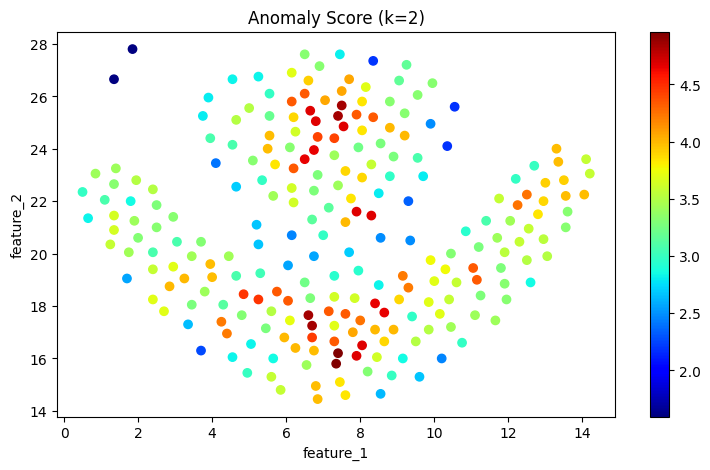

Anomaly Score (k=5)
|     |   feature_1 |   feature_2 |   Anomaly score |
|----:|------------:|------------:|----------------:|
|   0 |        1.85 |       27.8  |        0.493581 |
|   1 |        1.35 |       26.65 |        0.506236 |
| 204 |       10.55 |       25.6  |        1.11846  |
| 192 |       10.35 |       24.1  |        1.13168  |
| 158 |        9.35 |       20.5  |        1.16028  |


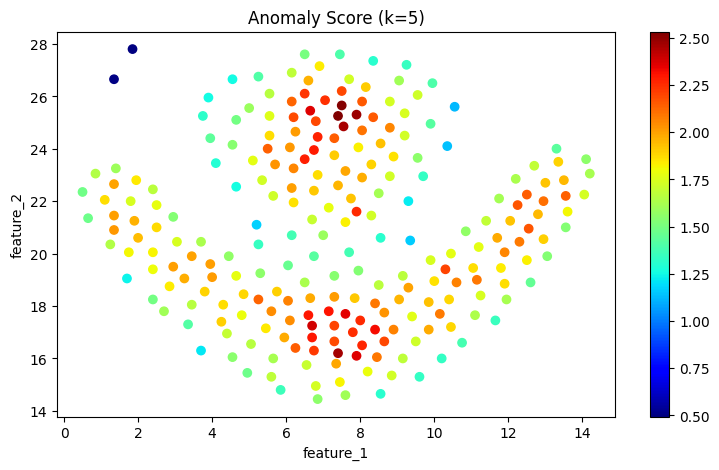

In [22]:
dbm_inverse_avg(flameX)

*Figure 9. Many figures of anomaly scores using a density-based (average) model*
- When k=1, we have zero division error -> inf
- With increased distance (neighbours) we have greater anomaly given the decreased density  
  - the lowest density (anomaly score) implies bigger anomaly 
  - the density is based on the averaged distances of rows for different k 

# <font color='violet'>PathBased</font>

Anomaly Score (k=1)
|    |   feature_1 |   feature_2 |   Anomaly score |
|---:|------------:|------------:|----------------:|
|  0 |       11.25 |        5.05 |             inf |
|  1 |       10.95 |        4.7  |             inf |
|  2 |        9.85 |        5.8  |             inf |
|  3 |        9.8  |        5.75 |             inf |
|  4 |        9.15 |        6.8  |             inf |


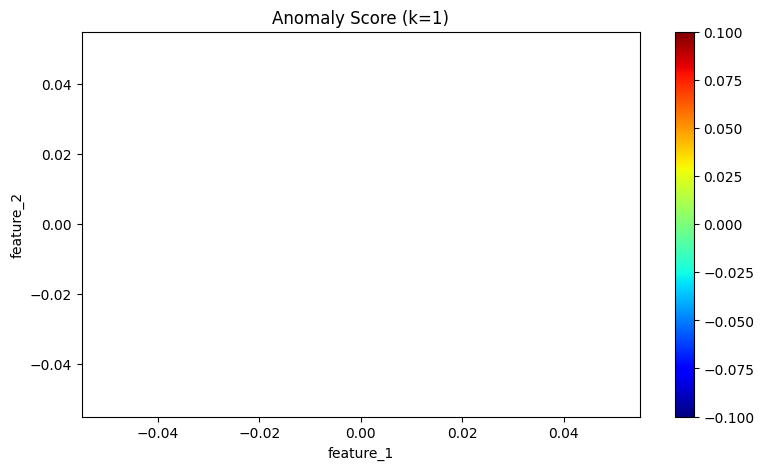

Anomaly Score (k=2)
|     |   feature_1 |   feature_2 |   Anomaly score |
|----:|------------:|------------:|----------------:|
| 202 |       12.45 |        9.15 |        0.794772 |
| 203 |       10.1  |       10.05 |        0.828671 |
| 270 |       10.3  |       22.75 |        0.878326 |
| 266 |        7.45 |       19    |        1.16248  |
| 106 |       29.15 |       16.5  |        1.30396  |


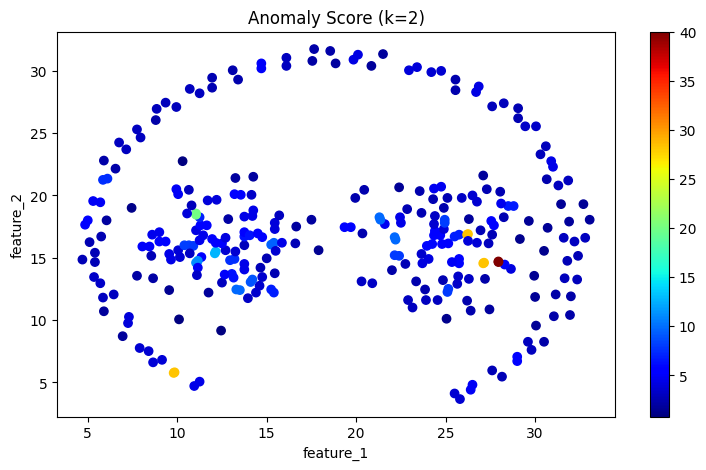

Anomaly Score (k=5)
|     |   feature_1 |   feature_2 |   Anomaly score |
|----:|------------:|------------:|----------------:|
| 202 |       12.45 |        9.15 |        0.414761 |
| 203 |       10.1  |       10.05 |        0.478595 |
| 270 |       10.3  |       22.75 |        0.486036 |
| 266 |        7.45 |       19    |        0.610883 |
| 294 |       17.9  |       15.6  |        0.611815 |


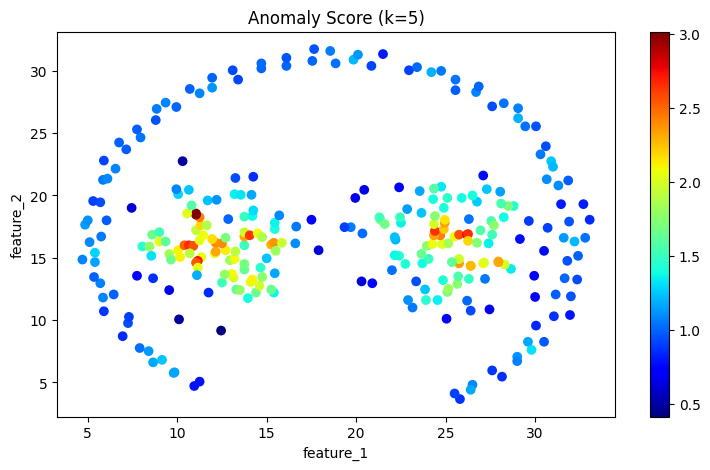

In [23]:
dbm_inverse_avg(pathbasedX)

*Figure 10. Many figures of anomaly scores using a density-based (average) model*
- When k=1, we have zero division error -> inf
- With increased distance (neighbours) we have greater anomaly given the decreased density  
  - the lowest density (anomaly score) implies bigger anomaly 
  - the density is based on the averaged distances of rows for different k 

### Observations
Compared to **A** (simple inverse distance approach), the anomaly score results in **B** (average inverse distance approach) show that the anomalies have a larger density than those in A.